# Set up

In [1]:
%matplotlib inline
%run fcast.py

# customize matplotlib plots
mpl.style.use('seaborn-darkgrid')
plt.rc('font', family='TH Sarabun New')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes',  labelsize=16)
plt.rc('figure', figsize=(6.5,4), dpi=300)

# Prepare Data

In [2]:
hml = read_price('hml')
hml.meta = SimpleNamespace()
hml.meta.abb = 'hml'
hml.meta.shortname = 'ข้าวหอมมะลิ'
hml.meta.fullname = 'ราคาข้าวเปลือกหอมมะลิ ที่เกษตรกรขายได้ ณ ไร่นา'

wht = read_price('wht')
wht.meta = SimpleNamespace()
wht.meta.abb = 'wht'
wht.meta.shortname = 'ข้าวเจ้าขาว'
wht.meta.fullname = 'ราคาข้าวเปลือกเจ้าขาว ที่เกษตรกรขายได้ ณ ไร่นา'

glu = read_price('glu')
glu.meta = SimpleNamespace()
glu.meta.abb = 'glu'
glu.meta.shortname = 'ข้าวเหนียว'
glu.meta.fullname = 'ราคาข้าวเปลือกเหนียวเมล็ดยาว ที่เกษตรกรขายได้ ณ ไร่นา'

prices = [hml, wht, glu]

In [3]:
for price in prices:
  price.scaled, price.scaler = data_transform(price, method="log")
#   price.scaled, price.scaler = data_transform(price, method=None)
  price.train, price.validate, price.train2, price.test = data_split(price.scaled)
  print(price.meta.abb, price.train.size, price.validate.size, price.test.size)

hml 259 85 85
wht 259 85 85
glu 259 85 85


# ARIMA

## Generate Parameters Grid

In [4]:
p = list(range(3))
q = list(range(3))
P = [0, 1]
Q = [0, 1]
t = ['c']
m = 12
order = model_configs(p, [1], q)
sorder = model_configs(P, [0], Q, [12])
arima_configs = model_configs(order, sorder, t)
arima_configs

[((0, 1, 0), (0, 0, 0, 12), 'c'),
 ((0, 1, 0), (0, 0, 1, 12), 'c'),
 ((0, 1, 0), (1, 0, 0, 12), 'c'),
 ((0, 1, 0), (1, 0, 1, 12), 'c'),
 ((0, 1, 1), (0, 0, 0, 12), 'c'),
 ((0, 1, 1), (0, 0, 1, 12), 'c'),
 ((0, 1, 1), (1, 0, 0, 12), 'c'),
 ((0, 1, 1), (1, 0, 1, 12), 'c'),
 ((0, 1, 2), (0, 0, 0, 12), 'c'),
 ((0, 1, 2), (0, 0, 1, 12), 'c'),
 ((0, 1, 2), (1, 0, 0, 12), 'c'),
 ((0, 1, 2), (1, 0, 1, 12), 'c'),
 ((1, 1, 0), (0, 0, 0, 12), 'c'),
 ((1, 1, 0), (0, 0, 1, 12), 'c'),
 ((1, 1, 0), (1, 0, 0, 12), 'c'),
 ((1, 1, 0), (1, 0, 1, 12), 'c'),
 ((1, 1, 1), (0, 0, 0, 12), 'c'),
 ((1, 1, 1), (0, 0, 1, 12), 'c'),
 ((1, 1, 1), (1, 0, 0, 12), 'c'),
 ((1, 1, 1), (1, 0, 1, 12), 'c'),
 ((1, 1, 2), (0, 0, 0, 12), 'c'),
 ((1, 1, 2), (0, 0, 1, 12), 'c'),
 ((1, 1, 2), (1, 0, 0, 12), 'c'),
 ((1, 1, 2), (1, 0, 1, 12), 'c'),
 ((2, 1, 0), (0, 0, 0, 12), 'c'),
 ((2, 1, 0), (0, 0, 1, 12), 'c'),
 ((2, 1, 0), (1, 0, 0, 12), 'c'),
 ((2, 1, 0), (1, 0, 1, 12), 'c'),
 ((2, 1, 1), (0, 0, 0, 12), 'c'),
 ((2, 1, 1), (

## Define functions
- arima_fit
- arima_forecast
- arima_walk_forward

In [24]:
def arima_fit(data, config):
  order, sorder, trend = config
  return pm.arima.ARIMA(order, sorder, trend=trend).fit(data)

def arima_forecast(model_fitted, data, n_forecast=4):
  scaler = getattr(data, "scaler")
  df = pd.DataFrame(model_fitted.predict(n_forecast),
                    columns=["yhat_scaled"])
  df['yhat'] = scaler.inverse_transform(df)
  return df['yhat']

def arima_walk_forward(data, config, search_mode=False, n_forecast=4):
  # this ensures that we use transformed train and test set
  train, test = select_traintest(data, search_mode) 
  data_ = pd.concat([train, test])
  N = data_.shape[0]
  n_test = test.shape[0]
  n_yhat = n_test+1
  yhat = np.empty((n_yhat, n_forecast))
  
  history = train
  model_fitted = arima_fit(history, config)
  yhat[0] = arima_forecast(model_fitted, data, n_forecast)
  
  for i in range(1, n_yhat):
    model_fitted = model_fitted.update(test.iloc[i-1])
    yhat[i] = arima_forecast(model_fitted, data, n_forecast)
    history = history.append(test.iloc[i-1])

  yhat = pd.DataFrame(yhat,
                      columns=[f'yhat{h}' for h in range(1, n_forecast+1)],
                      index=data_.index[-n_test-1:])
  
  return yhat

In [26]:
# test
config = arima_configs[0]
fitted = arima_fit(hml.scaled[:-5], config)
yhat = arima_walk_forward(hml, config, search_mode=True)
scores = model_measure(hml, yhat, config)
scores

,rmse,mae,mape,rmse1,mae1,mape1,rmse2,mae2,mape2,rmse3,mae3,mape3,rmse4,mae4,mape4
"(0, 1, 0)-(0, 0, 0, 12)-c","1,232.6216",773.2640,0.0594,687.9508,398.8934,0.0311,"1,115.1392",706.7987,0.0546,"1,442.9527",923.7541,0.0709,"1,684.4437","1,063.6098",0.0810


# Run

In [27]:
arima_model = [arima_fit, arima_forecast, arima_walk_forward, arima_configs]

In [28]:
%%time
n_forecast=4
for price in prices:
  price.arima_grid_result, price.arima_config = grid_search(price, arima_model, n_forecast=n_forecast)
  price.arima_yhat = forecast(price, arima_model, price.arima_config, n_forecast=n_forecast)

{('(0, 1, 0)-(0, 0, 0, 12)-c',): {'rmse': 1232.6216, 'mae': 773.264, 'mape': 0.0594}}
{('(0, 1, 0)-(0, 0, 1, 12)-c',): {'rmse': 1244.5367, 'mae': 786.3214, 'mape': 0.0605}}
{('(0, 1, 0)-(1, 0, 0, 12)-c',): {'rmse': 1256.7996, 'mae': 801.1276, 'mape': 0.0616}}
{('(0, 1, 0)-(1, 0, 1, 12)-c',): {'rmse': 1279.4474, 'mae': 777.4817, 'mape': 0.0582}}
{('(0, 1, 1)-(0, 0, 0, 12)-c',): {'rmse': 1219.4839, 'mae': 766.2186, 'mape': 0.0588}}
{('(0, 1, 1)-(0, 0, 1, 12)-c',): {'rmse': 1223.8273, 'mae': 775.5375, 'mape': 0.0596}}
{('(0, 1, 1)-(1, 0, 0, 12)-c',): {'rmse': 1232.0675, 'mae': 787.0472, 'mape': 0.0605}}
{('(0, 1, 1)-(1, 0, 1, 12)-c',): {'rmse': 1259.4474, 'mae': 764.6902, 'mape': 0.0573}}
{('(0, 1, 2)-(0, 0, 0, 12)-c',): {'rmse': 1222.5605, 'mae': 768.7175, 'mape': 0.0589}}
{('(0, 1, 2)-(0, 0, 1, 12)-c',): {'rmse': 1228.9637, 'mae': 779.247, 'mape': 0.0598}}
{('(0, 1, 2)-(1, 0, 0, 12)-c',): {'rmse': 1233.9889, 'mae': 788.0981, 'mape': 0.0605}}
{('(0, 1, 2)-(1, 0, 1, 12)-c',): {'rmse': 125

In [29]:
for price in prices:
  print(price.arima_config)

((1, 1, 2), (0, 0, 0, 12), 'c')
((1, 1, 2), (0, 0, 0, 12), 'c')
((2, 1, 1), (0, 0, 0, 12), 'c')


In [30]:
path = '../results/result_arima_4.pkl'

if(os.path.isfile(path)):
  result = joblib.load(path)
else:
  result = dict()
  for price in prices:
    result[price.meta.abb] = [price.arima_grid_result, price.arima_config, price.arima_yhat]
  joblib.dump(result, path)

In [32]:
hml.tail()

,y
date,
2019-05-01,"15,726.0000"
2019-06-01,"15,771.0000"
2019-07-01,"15,508.0000"
2019-08-01,"16,035.0000"
2019-09-01,"16,604.0000"


In [31]:
hml.arima_yhat

,yhat1,yhat2,yhat3,yhat4
date,,,,
2012-08-01,"15,563.9913","15,603.0377","15,647.3025","15,696.0790"
2012-09-01,"15,567.9481","15,612.3518","15,661.0870","15,713.5770"
2012-10-01,"15,935.4595","15,971.3535","16,013.1934","16,060.1660"
2012-11-01,"15,144.4967","15,219.2296","15,293.6322","15,367.7988"
2012-12-01,"15,538.4057","15,600.7671","15,664.9371","15,730.7073"
...,...,...,...,...
2019-05-01,"15,770.8353","15,788.1350","15,811.8131","15,840.9601"
2019-06-01,"15,788.6418","15,812.6907","15,842.1932","15,876.3802"
2019-07-01,"15,448.5525","15,494.1208","15,541.8183","15,591.3693"


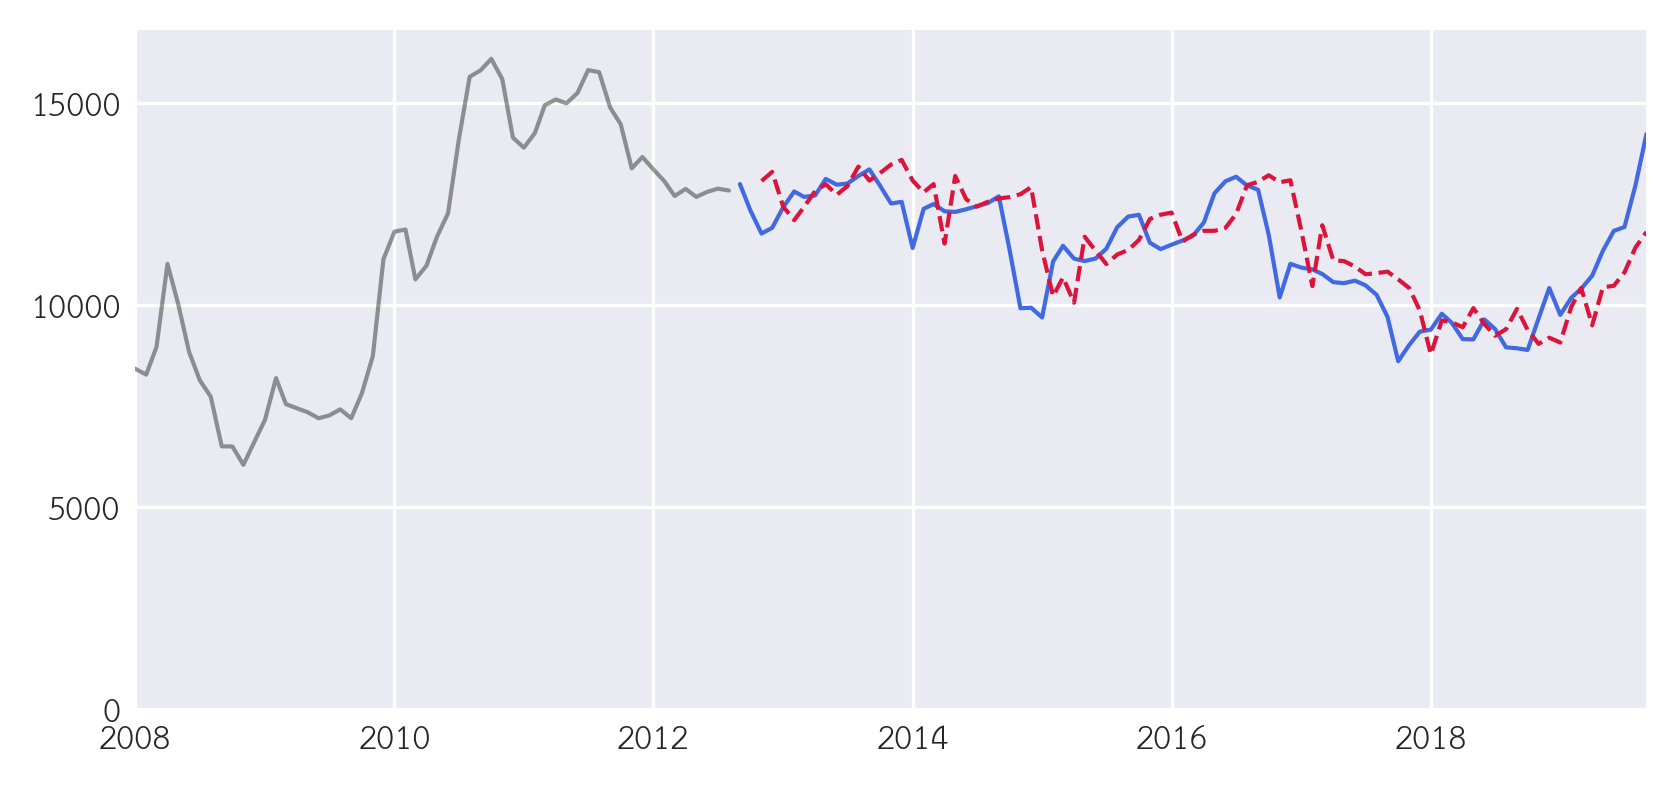

In [35]:
plot_fcast(glu, 'arima', step=4)

In [36]:
model_measure(hml, hml.arima_yhat, [""])

,rmse,mae,mape,rmse1,mae1,mape1,rmse2,mae2,mape2,rmse3,mae3,mape3,rmse4,mae4,mape4
,926.3782,670.5727,0.0545,478.2798,329.7268,0.0269,827.1463,593.1281,0.0482,"1,089.1806",784.3278,0.0638,"1,310.9061",975.1080,0.0791


In [38]:
model_measure(wht, wht.arima_yhat, [""])

,rmse,mae,mape,rmse1,mae1,mape1,rmse2,mae2,mape2,rmse3,mae3,mape3,rmse4,mae4,mape4
,497.9089,382.2650,0.0476,288.7314,214.5631,0.0262,461.7035,373.2554,0.0464,581.4132,450.1570,0.0563,659.7876,491.0845,0.0616


In [39]:
model_measure(glu, glu.arima_yhat, [""])

,rmse,mae,mape,rmse1,mae1,mape1,rmse2,mae2,mape2,rmse3,mae3,mape3,rmse4,mae4,mape4
,863.8839,645.9053,0.0592,514.8356,362.1703,0.0333,796.3268,584.7623,0.0537,980.6102,752.2634,0.0691,"1,163.7630",884.4251,0.0806
